# Add coordinates

The `ref_african_crops_kenya_02` dataset has fake coordinates, as it was part of the [Computer Vision for Agriculture 2020](https://www.cv4gc.org/cv4a2020/) workshop challenge.

Here, we retrieve the original coordinates of the fields.

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
import mlhub

This code works by matching pixels to the original sentinel tile - this means the original sentinel tile must be downloaded to work. Here, it was downloaded from the [Copernicus Open Access hub](https://scihub.copernicus.eu/dhus/#/home). Note that the L2A product was downloaded, for tile T36NXF.

In [3]:
data_dir = Path("../data")

In addition, a specific date and band must be used for comparison. In this case, we use the tile from the 24th September 2019, and the B3 (Green) band is used.

In [4]:
date_string = "20190924"
band = "B03"

In [5]:
original_sentinel_tile = xr.open_rasterio(
    data_dir / f"S2B_MSIL2A_{date_string}T074639_N0213_R135_T36NXF_{date_string}T111745.SAFE/GRANULE/" /
    f"L2A_T36NXF_A013317_{date_string}T080925/IMG_DATA/R10m/T36NXF_{date_string}T074639_{band}_10m.jp2"
)

The subtile to match was downloaded using mlhub (see [Download.ipynb](Download.ipynb)):

```python
mlhub.download_collection(
    collection_id="ref_african_crops_kenya_02",
    download_path=download_location
)
```

We will be matching `tile=00`.

In [6]:
tile = "00"

In [7]:
subtile_to_match = xr.open_rasterio(
    data_dir / "ref_african_crops_kenya_02" / tile / date_string / f"{int(tile)}_{band}_{date_string}.tif"
)

/Users/gabrieltseng/anaconda3/envs/mlhub/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Note that the subtile to match has its values scaled by 10,000 compared to the original sentinel tile, which is why a scaling factor is used in the function:

In [8]:
x_start, y_start = mlhub.find_subarray_indices(
    reference_array=original_sentinel_tile,
    subarray=subtile_to_match,
    scaling_sub_to_ref=10000
)

We can check if the returned coordinates look right:

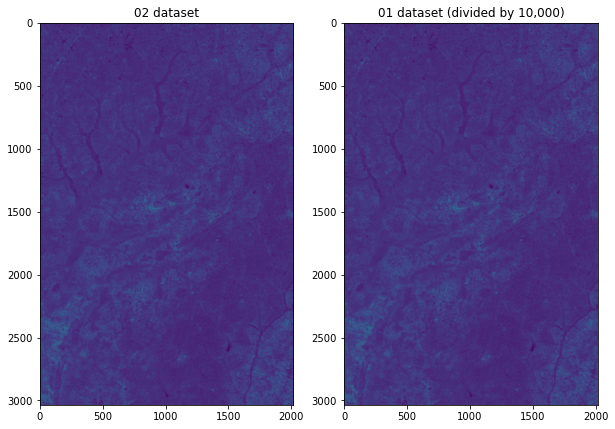

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 15))

ax[0].imshow(
    np.squeeze(subtile_to_match.values, 0), 
    vmin=subtile_to_match.min(), 
    vmax=subtile_to_match.max()
)

ax[1].imshow(
    np.squeeze(original_sentinel_tile.values, 0)[y_start: y_start + subtile_to_match.y.shape[0], x_start: x_start + subtile_to_match.x.shape[0]] / 10000, 
    vmin=subtile_to_match.min(), 
    vmax=subtile_to_match.max())

ax[0].set_title("02 dataset")
ax[1].set_title("01 dataset (divided by 10,000)")
plt.show()

Great! It looks like we have found the coordinates. We can now use them to update the labelled data (the fields tif files) with true coordinates.

In [10]:
field_id_tif = xr.open_rasterio(
    data_dir / "ref_african_crops_kenya_02" / tile / f"{int(tile)}_field_id.tif"
)

In [11]:
field_id_with_crds = mlhub.update_coords_and_attrs(
    original_sentinel_tile,
    da_to_update=field_id_tif,
    x_start=x_start,
    y_start=y_start
)

In [12]:
field_id_with_crds

<xarray.DataArray (band: 1, y: 3035, x: 2016)>
[6118560 values with dtype=int32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.880e+04 4.88e+04 4.878e+04 ... 1.848e+04 1.846e+04
  * x        (x) float64 6.137e+05 6.138e+05 6.138e+05 ... 6.339e+05 6.339e+05
Attributes:
    transform:                 (10.0, 0.0, 600000.0, 0.0, -10.0, 100020.0)
    res:                       (10.0, 10.0)
    is_tiled:                  0
    nodatavals:                (nan,)
    scales:                    (1.0,)
    offsets:                   (0.0,)
    TIFFTAG_IMAGEDESCRIPTION:  {"shape": [3035, 2016]}
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          tifffile.py
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    crs:                       +init=epsg:32636

Now, we can save it

In [13]:
field_id_with_crds.to_netcdf(
    data_dir / "ref_african_crops_kenya_02" / tile / f"{int(tile)}_field_id_with_crds.tif"
)

And do the same for the labels:

In [14]:
labels_tif = xr.open_rasterio(
    data_dir / "ref_african_crops_kenya_02" / tile / f"{int(tile)}_label.tif"
)

In [15]:
labels_with_crds = mlhub.update_coords_and_attrs(
    original_sentinel_tile,
    da_to_update=labels_tif,
    x_start=x_start,
    y_start=y_start
)

In [16]:
labels_with_crds.to_netcdf(
    data_dir / "ref_african_crops_kenya_02" / tile / f"{int(tile)}_label_with_crds.tif"
)